In [67]:
# import functions needed for GBM model
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.grid_search import GridSearchCV   #Performing grid search
import matplotlib.pyplot as plt


In [68]:
companies = ['AAPL', 'MSFT', 'AMZN', 'INTC', 'TSLA']
# all_data = dict.fromkeys(companies, pd.DataFrame())

#first two dataframes are the X_train and y_train
# second two dataframes are the X_test and y_test
all_data = dict.fromkeys(companies, [pd.DataFrame(),pd.DataFrame,pd.DataFrame,pd.DataFrame])

In [69]:
split_percentage = 0.8
for comp in companies:
    current_comp = pd.read_csv(f'./rsc/{comp}_data.csv', sep = ',')
    current_comp = current_comp.dropna()
    current_comp['Open-Close'] = current_comp.open - current_comp.close
    current_comp['High-Low'] = current_comp.high - current_comp.low
    split = int(split_percentage*len(current_comp['date']))
    all_data[comp][0] = current_comp[current_comp.columns[:]][:split]
    y = np.where(current_comp['close'].shift(-1) > current_comp['close'],1,-1)
    all_data[comp][1] = y[:split]
    all_data[comp][2] = current_comp[current_comp.columns[:]][split:]
    all_data[comp][3] = y[split:]

In [70]:
all_data['AAPL'][2].head()

,date,20_day_sma,close,ewma_12,ewma_26,high,low,obv_10,open,rsi_14,volume,Open-Close,High-Low
576,2017-05-15,312.107085,315.88,315.708868,307.743271,320.20,312.53,-796403.8,318.38,71.25,7568594.0,2.50,7.67
577,2017-05-16,312.945085,317.01,315.909042,308.429696,320.06,315.14,-836092.7,317.59,72.87,4121619.0,0.58,4.92
578,2017-05-17,312.974585,306.11,314.401497,308.257866,314.63,305.50,1126907.1,314.39,86.05,6675795.0,8.28,9.13
579,2017-05-18,313.502085,313.06,314.195113,308.613580,313.94,305.31,-145458.8,307.00,86.66,5590416.0,-6.06,8.63
580,2017-05-19,313.763585,310.83,313.677403,308.777759,316.50,310.20,124702.6,315.50,76.38,4639506.0,4.67,6.30


In [71]:
# optimum parameters found from ML_Model_Training
parameter_dict = {
    'max_depth': 7,
    'min_samples_split': 420,
    'min_samples_leaf': 30,
    'subsample': 0.8,
    'random_state': 10,
    'max_features': 11
}

col_list = all_data['AAPL'][0].columns[1:]

In [72]:
col_list

Index(['20_day_sma', 'close', 'ewma_12', 'ewma_26', 'high', 'low', 'obv_10',
       'open', 'rsi_14', 'volume', 'Open-Close', 'High-Low'],
      dtype='object')

In [73]:
# first two dataframes are the X_train and y_train
# second two dataframes are the X_test and y_test
def model_fit(alg, X_train, predictors, y_train, X_test, y_test, company_name, performCV=True, printFeatureImportance=True, cv_folds=5):
    # model_fit(gbm0, all_data[comp][0], predictors, all_data[comp][1], company_name = comp)
    # Fit algorithm on the data
    alg.fit(X_train[predictors], y_train)
    
    # Predict training set
    X_train_predictions = alg.predict(X_test[predictors])
    X_train_predprob = alg.predict_proba(X_test[predictors])[:,1]
    
    # Perform Cross-validation
    if performCV:
        cv_score = cross_val_score(alg, X_test[predictors], y = y_test, cv=cv_folds, scoring = 'roc_auc')

    #Print model report:
    print (f"\n{company_name} Model Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test[0:len(y_test)], X_train_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, X_train_predprob))
    
#     if performCV:
#         print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
            
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        

In [61]:
# all_data['AAPL'][2][all_data['AAPL'][0].columns[1:len(all_data['AAPL'][0])]]


AAPL Model Report
Accuracy : 0.6069
AUC Score (Train): 0.644832

MSFT Model Report
Accuracy : 0.6069
AUC Score (Train): 0.644832


ValueError: Number of features of the model must match the input. Model n_features is 12 and input n_features is 13 

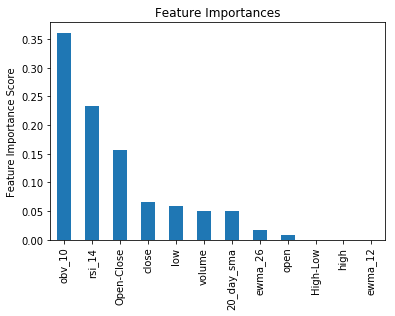

In [74]:
gbm0 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=parameter_dict['max_depth'], min_samples_split=parameter_dict['min_samples_split'], min_samples_leaf= parameter_dict['min_samples_leaf'], subsample=parameter_dict['subsample'], random_state=parameter_dict['random_state'], max_features=parameter_dict['max_features'])

# Choose predictors test model accuracy
for comp in companies:
    predictors = all_data[comp][0].columns[1:len(all_data[comp][0])]
    model_fit(alg = gbm0, X_train = all_data[comp][0], predictors = predictors, y_train = all_data[comp][1], company_name = comp, X_test = all_data[comp][2], y_test = all_data[comp][3] )
    all_data[comp][2]['Predicted_Signal'] = gbm0.predict(all_data[comp][2][all_data[comp][2].columns[1:]])
    

In [9]:
all_data['AAPL'].head()

,date,20_day_sma,close,ewma_12,ewma_26,high,low,obv_10,open,rsi_14,volume,Open-Close,High-Low,Predicted_Signal
0,2015-01-30,110.6415,117.16,113.100715,111.782535,120.00,116.850,36869040.5,118.40,91.43,83745461.0,1.24,3.150,1
1,2015-02-02,111.1065,118.63,113.977641,112.415496,119.17,116.080,37070624.7,118.05,92.46,62739100.0,-0.58,3.090,1
2,2015-02-03,111.7265,118.65,114.715157,112.981405,119.09,117.610,39228009.3,118.50,88.13,51915749.0,-0.15,1.480,1
3,2015-02-04,112.3915,119.56,115.476853,113.568741,120.51,118.309,38072992.9,118.50,72.85,70149743.0,-1.06,2.201,1
4,2015-02-05,113.0010,119.94,116.176181,114.129045,120.23,119.250,29055853.4,120.02,74.42,42246245.0,0.08,0.980,1


In [10]:
# predict the buy/sell signals of the test dataset
# evaluate against the model in the train dataset
for comp in all_data:
    company = all_data[comp]
    # Calculate log returns
    company['Return'] = np.log(company.close.shift(-1) / company.close)*100
    company['Strategy_Return'] = company.Return * company.Predicted_Signal
    company.set_index('date', inplace=True)

In [11]:
all_data['AAPL'].head()

,20_day_sma,close,ewma_12,ewma_26,high,low,obv_10,open,rsi_14,volume,Open-Close,High-Low,Predicted_Signal,Return,Strategy_Return
date,,,,,,,,,,,,,,,
2015-01-30,110.6415,117.16,113.100715,111.782535,120.00,116.850,36869040.5,118.40,91.43,83745461.0,1.24,3.150,1,1.246888,1.246888
2015-02-02,111.1065,118.63,113.977641,112.415496,119.17,116.080,37070624.7,118.05,92.46,62739100.0,-0.58,3.090,1,0.016858,0.016858
2015-02-03,111.7265,118.65,114.715157,112.981405,119.09,117.610,39228009.3,118.50,88.13,51915749.0,-0.15,1.480,1,0.764035,0.764035
2015-02-04,112.3915,119.56,115.476853,113.568741,120.51,118.309,38072992.9,118.50,72.85,70149743.0,-1.06,2.201,1,0.317328,0.317328
2015-02-05,113.0010,119.94,116.176181,114.129045,120.23,119.250,29055853.4,120.02,74.42,42246245.0,0.08,0.980,1,-0.845653,-0.845653


In [12]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

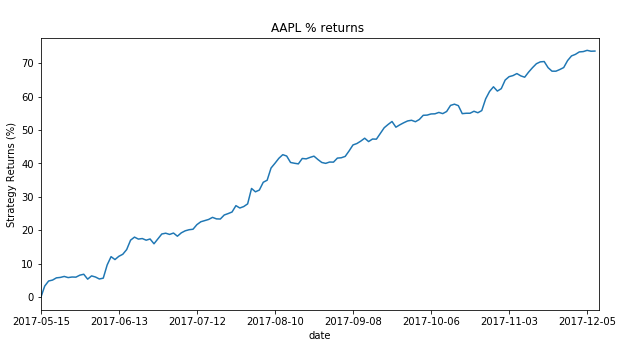

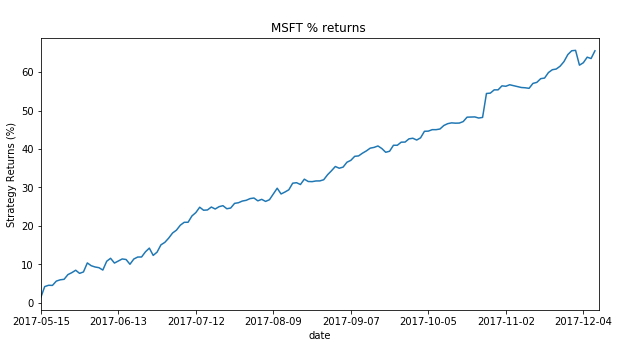

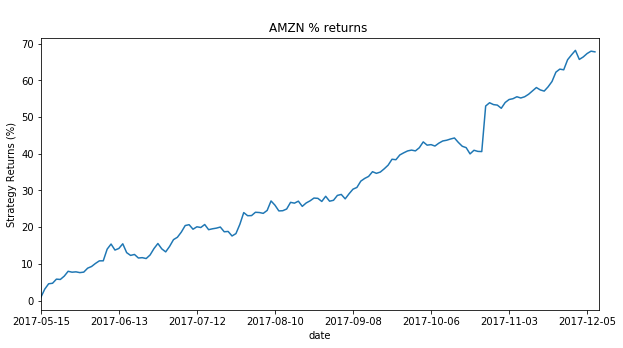

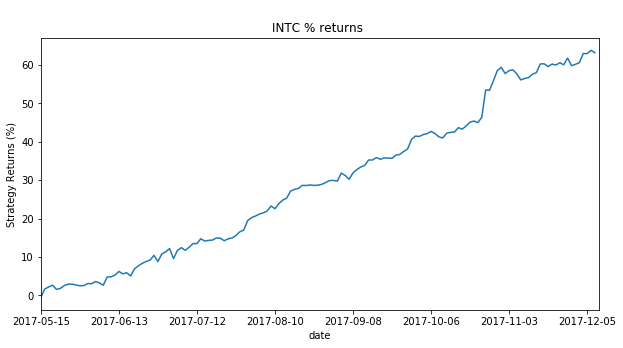

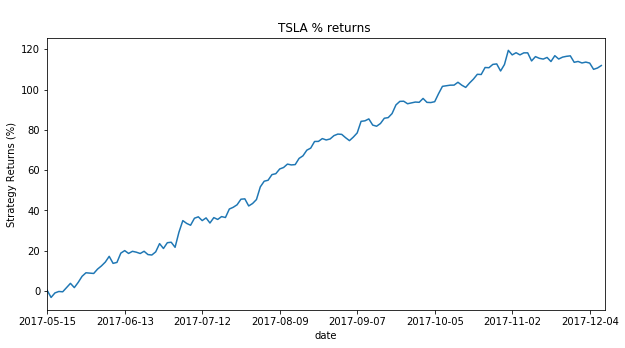

In [13]:

for comp in all_data:
    company = all_data[comp]
    company.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
    plt.ylabel("Strategy Returns (%)")
    plt.title(f'\n{comp} % returns ')
    plt.show()